In [1]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

import numpy as np
import tqdm
import scanpy as sc
import os

from huggingface_hub import hf_hub_download

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import joblib

from grnndata import read_h5ad

from matplotlib import pyplot as plt
from scdataloader import utils as data_utils

from pyvis import network as pnx
import networkx as nx
import scipy.sparse
import gseapy as gp
from gseapy import dotplot

from scdataloader.utils import revert_to_raw

import scipy.sparse

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/ctxcore/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
LOC = "/pasteur/appa/scratch/jkalfon/data/"

name = "Macrophage"

In [3]:
grn_m = read_h5ad(LOC + f"grn_task4_mouse_{name}.h5ad")
grn_h = read_h5ad(LOC + f"grn_task4_human_{name}.h5ad")

In [4]:
grn_m.var["symbol"] = grn_m.var.symbol.str.upper()

In [5]:
# between the two networks we have ~3000 genes in common over their 4000 genes
grn_m.var.index = grn_m.var.symbol.str.upper()
common = set(grn_h.var.index) & set(grn_m.var.index)
len(common)

2978

In [45]:
# hub genes based on edge centrality (number of connections / strength of connections)
grn_h.grn.sum(0).sort_values(ascending=False).head(30)

index
FTL         67.522400
B2M         63.816372
TMSB4X      54.556316
NLN         51.200565
FTH1        43.270775
HLA-DRA     40.650234
TXNIP       38.062641
EIF1        35.565845
C1QA        25.740410
UBXN1       25.120731
LYZ         23.978209
ITGB2       23.338360
CD74        23.209900
RPS14       22.008221
GABARAP     21.861885
SOD2        21.790438
ACTB        20.383188
C1QB        20.347918
PPIA        20.202841
C1QC        19.605148
RPS27A      19.256315
SPIC        19.180021
RPS6        18.481428
ALB         18.100208
ALOX5AP     17.430592
SRGN        17.301922
DMRT2       16.415487
IFI30       16.027319
SH3BGRL3    14.680469
RPL7        13.885112
dtype: float32

In [46]:
# without taking in account genes that are not present in the mouse network
grn_h.grn.sum(0).loc[list(common)].sort_values(ascending=False).head(30)

index
B2M        63.816372
TMSB4X     54.556316
FTH1       43.270775
ITGB2      23.338360
CD74       23.209900
RPS14      22.008221
SOD2       21.790438
PPIA       20.202841
C1QC       19.605148
SPIC       19.180021
RPS6       18.481428
ALB        18.100208
SRGN       17.301922
IFI30      16.027319
RPS19      13.683068
CD163      13.305556
CST3       13.139258
RPLP1      11.228999
MYL6       11.163845
PTP4A1     11.134760
S100A11    10.099115
CD3D       10.072865
VSIG4       9.813706
OLR1        9.525496
S100A4      9.370368
HMOX1       9.352107
CTSD        8.292619
XAF1        7.860425
VIM         7.456419
CXCL3       7.263704
dtype: float32

ACTB=ACTB (most expressed in B cell, motility, key linked gene is CFL1 top 10 in
mouse)

B2M=B2M (serum protein found in association with the major histocompatibility
complex, linked to HLA-C, top 20 in human genes)

TMSB4X = TMSB10, TMSB4X (Thymosin Beta, cell prolif, highly linked to actin and
ACTB)

CD83, CD52 = CD52 CD3D, (CD74) ( immunoglobulin superfamily of receptors,
Regulate b cell function, esp CD83, CD52 less)

S100A5 = S100A6 (key cell process regulation with calcium binding, both in top 3
relation to TOP53)

RPL41, RPL3 = RPL10, RPLP1 (ribosomal proteins, much more for human in top50,
highly co-regulated, often together, have in important impact on mRNA content by
working on splicing, mRNA stability, sequestration of TFs )

[RPS6] = RPS27A, RPS24, (RPS28) (same)

[FTL] = FTH1 (iron storage) MEF2C, JUNB (key TF in b cells,
https://pubmed.ncbi.nlm.nih.gov/12907453/,
https://pmc.ncbi.nlm.nih.gov/articles/PMC2518613/)

RGS2, RGS1, GPR183, GPX1 (G protein Receptor, signaling members, super important
b cell members)

JCHAIN, ITM2C, OGT, UBE2S, IFITM1, CREM, FCER1G, CST3 TOP2A, CRIP1, PPP1R15A,
MS4A1, PPIA, PTMA

"Immunoglobulin Receptor Binding (GO:0034987)" JCHAIN "B cell activation", "host
pathogen pathways" IFITM1, FCER1G "B cell activation" MS4A1 == "virus detection"
PPIA, PPP1R15A "MHC Class II Protein Complex Binding" MS4A1, "HSPA1A" (MHC
related)(PPP1R15A;PTMA) "circadian rythm" CST3;CREM;OGT = TOP2A

() = in the non matching genes [] = in the top 50

can find homologs and might use some genes that are similar when others are not
available or expressed

bias on the 1000 cells and which ones had which genes expressed worked using
only human / mouse known orhologs, but some relationships might not have been
found

Generically, many genes with high importance in generic cellular processes, and
some with high importance in B cell function.

Even more interesting, many of these genes are listed in papers about the
transcriptional control dynamic of B cell function using paired single cell
ATAC-seq - CHip-seq - RNA-seq
https://www.biorxiv.org/content/10.1101/2022.02.23.481342v2.full.pdf
"Fate-resolved gene regulatory signatures of individual B lymphocytes in the
early1stages of Epstein-Barr Virus infection2" (PPP1R-, TOP2A, MS4A1,
FCER2/FCER1G, JCHAIN, FTH1, FTL, TMSB10, TMSB4X, GPR183, (likely other members
of the G protein family), numerous ribosomal subunit genes (listed as example:
RPS27A) and also))


In [25]:
# Assuming 'node_names' contains the list of gene names.
# Note: it seems with enrichr, one can only use one gene set at a time, choose accordingly
enr = gp.enrichr(
    gene_list=grn_h.grn.sum(0).sort_values(ascending=False).head(100).index.tolist(),
    gene_sets=[
        "PPI_Hub_Proteins"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=grn_h.var.symbol.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.1].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,PPI_Hub_Proteins,ARRB2,2.760333e-09,6.735212e-07,0,0,8.107789,159.787610,HSP90AB1;RPL21;RPL31;RPLP1;RPS6;KCNAB1;RPS3A;A...
1,PPI_Hub_Proteins,GABARAPL1,1.400663e-08,1.708809e-06,0,0,5.896928,106.638481,DDX17;HSP90AB1;RPL21;RPL31;RPLP1;RPS6;GABARAP;...
2,PPI_Hub_Proteins,GABARAPL2,2.783924e-08,2.264258e-06,0,0,5.624417,97.846967,DDX17;CSTA;HSP90AB1;RPL10;RPL21;RPL31;RPLP1;RP...
3,PPI_Hub_Proteins,HNRNPK,7.954019e-07,4.851952e-05,0,0,9.071895,127.409494,EEF1A1;DDX17;RPS14;RPS19;RPL31;RPS3A;GABARAP;A...
4,PPI_Hub_Proteins,EIF2C1,1.721510e-06,7.202212e-05,0,0,9.652400,128.109636,EEF1A1;HSP90AB1;RPL10;RPL21;RPL31;RPS6;RPS3A;R...
5,PPI_Hub_Proteins,MAP1LC3B,1.771036e-06,7.202212e-05,0,0,5.935865,78.614281,DDX17;CSTA;HSP90AB1;RPL21;RPLP1;GABARAP;ACTB;E...
6,PPI_Hub_Proteins,ACTB,3.650760e-06,1.272550e-04,0,0,5.524697,69.172386,HSP90AB1;RPLP1;RPS3A;GABARAP;ACTB;RPL7;ACTG1;E...
7,PPI_Hub_Proteins,EIF2C2,4.679810e-06,1.427342e-04,0,0,10.094203,123.878611,EEF1A1;HSP90AB1;RPL21;RPL31;RPS6;RPS3A;RPS27A;...
8,PPI_Hub_Proteins,MAP1LC3A,5.655613e-06,1.533300e-04,0,0,4.919897,59.446432,DDX17;HSP90AB1;RPL21;RPL31;RPLP1;GABARAP;ACTB;...
9,PPI_Hub_Proteins,MAP3K1,6.400929e-06,1.561827e-04,0,0,8.074984,96.569277,RPS14;HSP90AB1;RPL10;RPS6;VIM;RPS27A;ACTB;RPL7...


In [24]:
# Assuming 'node_names' contains the list of gene names.
# Note: it seems with enrichr, one can only use one gene set at a time, choose accordingly
enr = gp.enrichr(
    gene_list=grn_m.grn.sum(0).sort_values(ascending=False).head(100).index.tolist(),
    gene_sets=[
        "PPI_Hub_Proteins"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="mouse",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=grn_m.var.symbol.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.1].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,PPI_Hub_Proteins,MAP3K14,6.192883e-11,1.339306e-08,0,0,15.487931,364.044366,HSPA8;DDX5;RPS9;RPL32;HSPA5;RPL11;TUBA4A;RPS3;...
1,PPI_Hub_Proteins,GABARAP,1.030236e-10,1.339306e-08,0,0,7.638191,175.648322,SRRM2;HSPA8;DDX5;RPS9;HSPA5;ARG1;RPLP1;RPL11;T...
2,PPI_Hub_Proteins,GABARAPL1,1.824240e-10,1.581008e-08,0,0,7.370146,165.273214,HSPA8;DDX5;RPS9;HSPA5;RPLP1;RPL11;RPL13A;TUBA4...
3,PPI_Hub_Proteins,GABARAPL2,3.687928e-10,2.397154e-08,0,0,7.051163,153.156798,HSPA8;DDX5;RPS9;HSPA5;ARG1;RPLP1;RPL11;RPL13A;...
4,PPI_Hub_Proteins,MAP1LC3A,3.071163e-09,1.412018e-07,0,0,7.405005,145.147046,SRRM2;HSPA8;DDX5;RPS9;HSPA5;RPLP1;RPL11;TUBA4A...
5,PPI_Hub_Proteins,EIF2C1,3.258503e-09,1.412018e-07,0,0,12.272727,239.833611,RPS26;DDX5;RPS9;RPL18A;RPL11;RPS3;RPL13A;RPL13...
6,PPI_Hub_Proteins,EIF2C2,8.984151e-08,3.336970e-06,0,0,11.713748,190.058118,RPS26;DDX5;RPS9;RPL18A;RPL11;RPS3;RPL13A;RPS2;...
7,PPI_Hub_Proteins,ESR1,4.237003e-07,1.377026e-05,0,0,4.847830,71.138218,SRRM2;HSPA8;DDX5;RPS9;HSPA5;ARG1;RPL11;RPL13A;...
8,PPI_Hub_Proteins,SLC2A4,1.242890e-06,3.590571e-05,0,0,4.468641,60.764901,HSPA8;RPS9;HSPA5;ARG1;RPL11;NME2;RPL13A;RPL18A...
9,PPI_Hub_Proteins,MAP1LC3B,2.449071e-06,6.367584e-05,0,0,6.253392,80.792587,SRRM2;HSPA8;DDX5;HSPA5;RPLP1;PRDX1;RPL11;ALB;R...


In [ ]:
INTerferon induced genes are among the top hub genes in human but not in mouse

In [ ]:
APOE
FCNA
SRRM2
MRC1
IGFBP7
WFDC17
CFP
ITM2B
NDFIP1
NME2
DDX5
VSIG4
ZBTB20
TUBA4A

In [ ]:
IFI30 - IFITM3 INTerferon induced transmembrane protein 3 and thiol reductase involved in MHC class II antigen processing


In [ ]:
NLN
HLA - DRA
TXNIP
EIF1
UBXN1
LYZ
ITGB2
GABARAP
SOD2
ACTB
PPIA
SPIC
ALOX5AP
SRGN
DMRT2
SH3BGRL

In [ ]:
CD27

In [ ]:
# Assuming 'node_names' contains the list of gene names.
# Note: it seems with enrichr, one can only use one gene set at a time, choose accordingly
enr = gp.enrichr(
    gene_list=[  # "JCHAIN", "ITM2C", "OGT", "UBE2S", "IFITM1", "CREM", "FCER1G", "CST3"],
        # "NLN",
        # "HLA-DRA",
        # "TXNIP",
        # "EIF1",
        # "UBXN1",
        # "LYZ",
        # "ITGB2",
        # "GABARAP",
        # "SOD2",
        # "ACTB",
        # "PPIA",
        # "SPIC",
        # "ALOX5AP",
        # "SRGN",
        # "DMRT2",
        # "SH3BGRL",
        # ],
        "APOE",
        "FCNA",
        "SRRM2",
        "MRC1",
        "IGFBP7",
        "WFDC17",
        "CFP",
        "ITM2B",
        "NDFIP1",
        "NME2",
        "DDX5",
        "VSIG4",
        "ZBTB20",
        "TUBA4A",
    ],
    # [
    #    "TOP2A",
    #    "CRIP1",
    #    "PPP1R15A",
    #    "MS4A1",
    #    "PPIA",
    #    "PTMA",
    # ], #["JCHAIN", "ITM2C", "OGT", "UBE2S", "IFITM1", "CREM", "FCER1G", "CST3"],
    gene_sets=[
        "WikiPathway_2023_Human"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=grn_h.var.symbol.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.1].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathway_2023_Human,Complement System WP2806,0.002909,0.042997,0,0,31.708683,185.175704,VSIG4;CFP
1,WikiPathway_2023_Human,ApoE And miR 146 In Inflammation And Atheroscl...,0.009407,0.042997,0,0,142.650000,665.640291,APOE
2,WikiPathway_2023_Human,Interactions Between LOXL4 And Oxidative Stres...,0.010968,0.042997,0,0,118.854167,536.364611,IGFBP7
3,WikiPathway_2023_Human,Lipid Particles Composition WP3601,0.010968,0.042997,0,0,118.854167,536.364611,APOE
4,WikiPathway_2023_Human,Alzheimer 39 S Disease And miRNA Effects WP2059,0.013818,0.042997,0,0,13.780788,59.006095,APOE;TUBA4A
5,WikiPathway_2023_Human,Alzheimer 39 S Disease WP5124,0.013818,0.042997,0,0,13.780788,59.006095,APOE;TUBA4A
6,WikiPathway_2023_Human,Familial Hyperlipidemia Type 3 WP5110,0.014082,0.042997,0,0,89.109375,379.862471,APOE
7,WikiPathway_2023_Human,Metabolic Pathway Of LDL HDL And TG Including ...,0.015635,0.042997,0,0,79.194444,329.307681,APOE
8,WikiPathway_2023_Human,Complement Activation WP545,0.018736,0.045800,0,0,64.772727,257.620082,CFP
9,WikiPathway_2023_Human,Melatonin Metabolism And Effects WP3298,0.023371,0.051417,0,0,50.866071,191.065387,APOE


In [ ]:
HUMAN
1	WikiPathway_2023_Human	Mechanoregulation And Pathology Of YAP TAZ Via...	0.001860	0.051145	0	0	38.006689	238.958204	ITGB2;ACTB
2	WikiPathway_2023_Human	Male Infertility WP4673	0.005202	0.052236	0	0	21.788462	114.578700	HLA-DRA;SOD2
3	WikiPathway_2023_Human	Acute Viral Myocarditis WP4298	0.005202	0.052236	0	0	21.788462	114.578700	ITGB2;ACTB
4	WikiPathway_2023_Human	Glucocorticoid Receptor Pathway WP2880	0.005448	0.052236	0	0	21.253283	110.784267	SRGN;ALOX5AP
5	WikiPathway_2023_Human	Selenium Micronutrient Network WP15	0.005698	0.052236	0	0	20.743590	107.193841	ALOX5AP;SOD2
Allograft Rejection	0.003408	0.047707	0	0	11.940171	67.840978	SRGN;ITGB2;HLA-DRA
0	GO_Molecular_Function_2023	K48-linked Polyubiquitin Modification-Dependen...	0.002622	0.055033	0	0	inf	inf	UBXN1
1	GO_Molecular_Function_2023	Ubiquitin Protein Ligase Binding (GO:0031625)	0.004653	0.055033	0	0	10.637405	57.124879	UBXN1;TXNIP;GABARAP
2	GO_Molecular_Function_2023	Ubiquitin-Like Protein Ligase Binding (GO:0044...	0.005693	0.055033	0	0	9.865248	50.988665	UBXN1;TXNIP;GABARAP
3	GO_Molecular_Function_2023	MHC Class II Receptor Activity (GO:0032395)	0.007848	0.056897	0	0	203.678571	987.336365	HLA-DRA
4	GO_Molecular_Function_2023	GABA Receptor Binding (GO:0050811)	0.010451	0.060615	0	0	135.761905	619.218567	GABARAP
5	GO_Molecular_Function_2023	Complement Component C3b Binding (GO:0001851)	0.015638	0.075584	0	0	81.428571	338.583502	ITGB2
6	GO_Molecular_Function_2023	Cyclosporin A Binding (GO:0016018)	0.023371	0.088566	0	0	50.866071	191.065387	PPIA
7	GO_Molecular_Function_2023	Ubiquitin Ligase-Substrate Adaptor Activity (G...	0.028495	0.088566	0	0	40.678571	144.735018	SH3BGRL
8	GO_Molecular_Function_2023	Ribosomal Small Subunit Binding (GO:0043024)	0.028495	0.088566	0	0	40.678571	144.735018	EIF1
9	GO_Molecular_Function_2023	Beta-Tubulin Binding (GO:0048487)	0.031048	0.088566	0	0	36.974026	128.382165	GABARAP

MOUSE
0	GO_Molecular_Function_2023	Amyloid-Beta Binding (GO:0001540)	0.002012	0.044950	0	0	38.564626	239.436015	APOE;ITM2B
1	GO_Molecular_Function_2023	G-quadruplex DNA Binding (GO:0051880)	0.004714	0.044950	0	0	356.812500	1911.551692	NME2
2	GO_Molecular_Function_2023	Phosphatidylcholine-Sterol O-acyltransferase A...	0.004714	0.044950	0	0	356.812500	1911.551692	APOE
3	GO_Molecular_Function_2023	C2H2 Zinc Finger Domain Binding (GO:0070742)	0.006280	0.044950	0	0	237.833333	1205.890220	SRRM2
4	GO_Molecular_Function_2023	Complement Component C3b Binding (GO:0001851)	0.009407	0.044950	0	0	142.650000	665.640291	VSIG4
5	GO_Molecular_Function_2023	Guanyl Ribonucleotide Binding (GO:0032561)	0.011047	0.044950	0	0	15.556172	70.090327	NME2;TUBA4A
6	GO_Molecular_Function_2023	WW Domain Binding (GO:0050699)	0.012526	0.044950	0	0	101.857143	446.130544	NDFIP1
7	GO_Molecular_Function_2023	Nucleoside Diphosphate Kinase Activity (GO:000...	0.012526	0.044950	0	0	101.857143	446.130544	NME2
8	GO_Molecular_Function_2023	Low-Density Lipoprotein Particle Receptor Bind...	0.014082	0.044950	0	0	89.109375	379.862471	APOE
9	GO_Molecular_Function_2023	Phosphotransferase Activity, Phosphate Group A...	0.014082	0.044950	0	0	89.109375	379.862471	NME2
10	GO_Molecular_Function_2023	mRNA Binding (GO:0003729)	0.016865	0.044950	0	0	12.363234	50.473384	SRRM2;DDX5
11	GO_Molecular_Function_2023	Nucleobase-Containing Compound Kinase Activity...	0.017187	0.044950	0	0	71.262500	289.582676	NME2
12	GO_Molecular_Function_2023	pre-mRNA Binding (GO:0036002)	0.017187	0.044950	0	0	71.262500	289.582676	DDX5
13	GO_Molecular_Function_2023	Lipoprotein Particle Receptor Binding (GO:0070...	0.021829	0.046386	0	0	54.788462	209.540593	APOE
14	GO_Molecular_Function_2023	Nuclear Androgen Receptor Binding (GO:0050681)	0.021829	0.046386	0	0	54.788462	209.540593	DDX5
15	GO_Molecular_Function_2023	R-SMAD Binding (GO:0070412)	0.021829	0.046386	0	0	54.788462	209.540593	DDX5
16	GO_Molecular_Function_2023	Promoter-Specific Chromatin Binding (GO:1990841)	0.024912	0.049824	0	0	47.466667	175.266110	DDX5
0	Reactome_2022	Metabolism Of Proteins R-HSA-392499	0.000344	0.034396	0	0	12.930719	103.122267	DDX5;IGFBP7;APOE;CFP;ITM2B;TUBA4A
1	Reactome_2022	Amyloid Fiber Formation R-HSA-977225	0.000936	0.046788	0	0	57.989796	404.429819	APOE;ITM2B
2	Reactome_2022	Chylomicron Clearance R-HSA-8964026	0.003145	0.082834	0	0	713.750000	4112.675946	APOE
3	Reactome_2022	Post-translational Protein Phosphorylation R-H...	0.003358	0.082834	0	0	29.381818	167.367878	IGFBP7;APOE
4	Reactome_2022	Regulation Of IGF Transport And Uptake By IGFB...	0.004218	0.082834	0	0	26.032258	142.355222	IGFBP7;APOE
5	Reactome_2022	Chylomicron Remodeling R-HSA-8963901	0.006280	0.082834	0	0	237.833333	1205.890220	APOE
6	Reactome_2022	Modulation By Mtb Of Host Immune System R-HSA-...	0.006280	0.082834	0	0	237.833333	1205.890220	MRC1
7	Reactome_2022	Post-translational Protein Modification R-HSA-...	0.007187	0.082834	0	0	7.567766	37.350912	DDX5;IGFBP7;APOE;CFP
8	Reactome_2022	Chylomicron Assembly R-HSA-8963888	0.007845	0.082834	0	0	178.343750	864.587514	APOE
9	Reactome_2022	mRNA Splicing - Major Pathway R-HSA-72163	0.009863	0.082834	0	0	16.536082	76.379846	SRRM2;DDX5
10	Reactome_2022	mRNA Splicing R-HSA-72172	0.010845	0.082834	0	0	15.711485	71.079400	SRRM2;DDX5
0	WikiPathway_2023_Human	Complement System WP2806	0.002909	0.042997	0	0	31.708683	185.175704	VSIG4;CFP
1	WikiPathway_2023_Human	ApoE And miR 146 In Inflammation And Atheroscl...	0.009407	0.042997	0	0	142.650000	665.640291	APOE
2	WikiPathway_2023_Human	Interactions Between LOXL4 And Oxidative Stres...	0.010968	0.042997	0	0	118.854167	536.364611	IGFBP7
3	WikiPathway_2023_Human	Lipid Particles Composition WP3601	0.010968	0.042997	0	0	118.854167	536.364611	APOE
4	WikiPathway_2023_Human	Alzheimer 39 S Disease And miRNA Effects WP2059	0.013818	0.042997	0	0	13.780788	59.006095	APOE;TUBA4A
5	WikiPathway_2023_Human	Alzheimer 39 S Disease WP5124	0.013818	0.042997	0	0	13.780788	59.006095	APOE;TUBA4A
6	WikiPathway_2023_Human	Familial Hyperlipidemia Type 3 WP5110	0.014082	0.042997	0	0	89.109375	379.862471	APOE
7	WikiPathway_2023_Human	Metabolic Pathway Of LDL HDL And TG Including ...	0.015635	0.042997	0	0	79.194444	329.307681	APOE
8	WikiPathway_2023_Human	Complement Activation WP545	0.018736	0.045800	0	0	64.772727	257.620082	CFP
9	WikiPathway_2023_Human	Melatonin Metabolism And Effects WP3298	0.023371	0.051417	0	0	50.866071	191.065387	APOE
10	WikiPathway_2023_Human	Statin Inhibition Of Cholesterol Production WP430	0.026451	0.052901	0	0	44.492188	161.616875	APOE
11	WikiPathway_2023_Human	Fatty Acids And Lipoproteins Transport In Hepa...	0.029521	0.054122	0	0	39.534722	139.266920	APOE

In [ ]:
TOP = 100
set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)

{'ACTB',
 'ATP1A1',
 'ATP4A',
 'B2M',
 'BIRC5',
 'CCDC89',
 'CCNB2',
 'CD3D',
 'CD52',
 'CD74',
 'CFL1',
 'CHAD',
 'COLQ',
 'COX7B',
 'COX8B',
 'CRIP1',
 'CTLA2A',
 'CYP2F2',
 'DUSP11',
 'FAM120B',
 'FCMR',
 'FTH1',
 'GIMAP4',
 'GM266',
 'H2-AA',
 'H2-AB1',
 'H2-EB1',
 'H3F3B',
 'HSP90AB1',
 'JCHAIN',
 'JUNB',
 'LIN54',
 'LY6D',
 'LYPD2',
 'MEF2C',
 'MPC1',
 'MRGPRF',
 'MS4A1',
 'MT-CYTB',
 'MT-ND1',
 'MT-ND2',
 'MT-ND4',
 'NDC80',
 'NWD1',
 'OXCT1',
 'PCDHGA12',
 'PCLAF',
 'PEX11G',
 'PPIA',
 'PPP1R15A',
 'PSME1',
 'PTMA',
 'PTPRB',
 'PTPRCAP',
 'RPL10',
 'RPL13',
 'RPL13A',
 'RPL14',
 'RPL18',
 'RPL18A',
 'RPL3',
 'RPL37',
 'RPL37A',
 'RPL38',
 'RPL39',
 'RPL4',
 'RPL6',
 'RPLP0',
 'RPLP1',
 'RPS12',
 'RPS16',
 'RPS17',
 'RPS18',
 'RPS19',
 'RPS23',
 'RPS24',
 'RPS27',
 'RPS27A',
 'RPS28',
 'RPS29',
 'RPS8',
 'RPSA',
 'RRM2',
 'S100A4',
 'S100A6',
 'SELENOP',
 'SLC25A5',
 'SNRPG',
 'TAF10',
 'TIFA',
 'TMEM132E',
 'TMEM176B',
 'TMSB10',
 'TMSB4X',
 'TOMM7',
 'TOP1',
 'TOP2A',
 'UBB',


In [47]:
# mouse hub genes
grn_m.grn.sum(0).sort_values(ascending=False).head(30)

symbol
C1QC       77.519073
TMSB4X     41.802864
APOE       40.588585
FCNA       39.359177
SRRM2      33.876957
MRC1       33.289558
RPL13A     32.056759
IGFBP7     31.896709
RPL11      27.574696
FTL1       27.434568
B2M        26.620033
IFITM3     26.154570
WFDC17     25.864525
CFP        21.936113
ITM2B      20.361074
NDFIP1     20.023716
CD52       19.125843
MT-CYTB    18.294144
NME2       17.928022
MT-ND1     17.800694
MT-ND4     17.678120
RPS24      17.041389
FTH1       16.653090
CD5L       16.438406
DDX5       15.556078
VSIG4      15.311343
ALB        15.164091
CD74       15.150368
ZBTB20     15.142496
TUBA4A     14.925520
dtype: float32

In [48]:
# without taking in account genes not present in the human network
grn_m.grn.sum(0).loc[list(common)].sort_values(ascending=False).head(30)

symbol
C1QC       77.519073
TMSB4X     41.802864
APOE       40.588585
SRRM2      33.876957
MRC1       33.289558
IGFBP7     31.896709
B2M        26.620033
IFITM3     26.154570
CFP        21.936113
CD52       19.125843
NME2       17.928022
FTH1       16.653090
CD5L       16.438406
VSIG4      15.311343
ALB        15.164091
CD74       15.150368
ZBTB20     15.142496
TUBA4A     14.925520
CTSD       14.200592
FN1        13.714249
TMEM218    12.782110
SLC25A5    12.569665
RPLP1      12.023596
FOLR2      11.515420
GRN        11.379998
HSPA8      11.121265
CXCL2      10.497538
ID3         9.898645
CLEC4F      9.694858
PRDX1       9.653316
dtype: float32

In [15]:
TOP = 20
set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index) & set(
    grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index
)

{'B2M', 'C1QC', 'TMSB4X'}

In [16]:
# top differential hubs
TOP = 100
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'TMEM218', 'SRRM2', 'GRN', 'SLC25A5', 'CFP', 'MPEG1', 'CHMP1B', 'ARG1', 'FOLR2', 'MX1', 'CLEC4F', 'APOA1', 'IFIT3', 'NUSAP1', 'ZFP36', 'ZBTB20', 'TUBA4A', 'KIF22', 'ID3', 'CD5L', 'HSPA8', 'APOE', 'MRC1', 'LPL', 'PLTP', 'HSPA5', 'IGFBP7', 'LGALS3', 'PTPRB', 'NME2', 'CD52', 'CXCL2', 'FN1', 'PRDX1', 'IFITM3'}
{'HMGN2', 'RPS14', 'EPSTI1', 'IFI30', 'S100A11', 'NR4A3', 'OLR1', 'SPARCL1', 'HMGB2', 'EGFL7', 'RPS6', 'CXCL3', 'S100A9', 'MYL6', 'CD163', 'NAMPT', 'PTP4A1', 'CTSL', 'HSP90AB1', 'S100A4', 'SRGN', 'COL1A2', 'VIM', 'SOD2', 'ITGB2', 'CST3', 'CD3D', 'XAF1', 'SPIC', 'HMOX1', 'FOXRED2', 'P2RY13', 'CCL4', 'MARCO', 'MS4A7'}


In [ ]:
{
    "TMEM218",
    "SRRM2",
    "GRN",
    "SLC25A5",
    "CFP",
    "MPEG1",
    "CHMP1B",
    "ARG1",
    "FOLR2",
    "MX1",
    "CLEC4F",
    "APOA1",
    "IFIT3",
    "NUSAP1",
    "ZFP36",
    "ZBTB20",
    "TUBA4A",
    "KIF22",
    "ID3",
    "CD5L",
    "HSPA8",
    "APOE",
    "MRC1",
    "LPL",
    "PLTP",
    "HSPA5",
    "IGFBP7",
    "LGALS3",
    "PTPRB",
    "NME2",
    "CD52",
    "CXCL2",
    "FN1",
    "PRDX1",
    "IFITM3",
}

{
    "HMGN2",
    "RPS14",
    "EPSTI1",
    "IFI30",
    "S100A11",
    "NR4A3",
    "OLR1",
    "SPARCL1",
    "HMGB2",
    "EGFL7",
    "RPS6",
    "CXCL3",
    "S100A9",
    "MYL6",
    "CD163",
    "NAMPT",
    "PTP4A1",
    "CTSL",
    "HSP90AB1",
    "S100A4",
    "SRGN",
    "COL1A2",
    "VIM",
    "SOD2",
    "ITGB2",
    "CST3",
    "CD3D",
    "XAF1",
    "SPIC",
    "HMOX1",
    "FOXRED2",
    "P2RY13",
    "CCL4",
    "MARCO",
    "MS4A7",
}

CXCL2 - CXCL3
CD52 - CD3D
PTP4A1 - PTPRB
HSPA8 / HSPA5 - HSP90AB1

In [ ]:
TREM
PPARG
CD36, CD9

In [58]:
TOP = 20
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'IGFBP7', 'NME2', 'SRRM2', 'CD52', 'APOE', 'MRC1', 'CFP', 'IFITM3'}
{'PPIA', 'ITGB2', 'FTH1', 'RPS14', 'CD74', 'SOD2'}


In [59]:
TOP = 50
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'IGFBP7', 'TUBA4A', 'FOLR2', 'NME2', 'TMEM218', 'SRRM2', 'CD52', 'CD5L', 'GRN', 'CTSD', 'HSPA8', 'APOE', 'FN1', 'MRC1', 'SLC25A5', 'CFP', 'IFITM3', 'ZBTB20'}
{'PPIA', 'ITGB2', 'PTP4A1', 'CST3', 'RPS14', 'CD3D', 'SPIC', 'IFI30', 'RPS6', 'SRGN', 'RPS19', 'SOD2', 'S100A11', 'OLR1', 'MYL6', 'CD163'}


In [ ]:
# we now compute eigen centrality creating a sparse network by only keeping the top 20 neighbors for each gene in the network
TOP = 20

grnutils.get_centrality(grn_h, TOP, top_k_to_disp=0)
grnutils.get_centrality(grn_m, TOP, top_k_to_disp=0)

Top central genes: []
Top central genes: []


[]

In [21]:
grn_h.var.centrality.sort_values(ascending=False).head(10)

index
TMSB4X     0.276147
B2M        0.276147
FTH1       0.276147
FTL        0.276147
HLA-DRA    0.276147
EIF1       0.276147
CD74       0.275399
C1QB       0.242367
C1QA       0.231694
PPIA       0.206782
Name: centrality, dtype: float64

In [22]:
grn_m.var.centrality.sort_values(ascending=False).head(10)

symbol
C1QC       0.274250
APOE       0.274250
TMSB4X     0.274250
B2M        0.274249
MT-CYTB    0.274011
MT-ND1     0.274002
FTH1       0.268971
MT-ND4     0.260279
FTL1       0.252664
IFITM3     0.217691
Name: centrality, dtype: float64

In [40]:
TOP = 10
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'C1QC', 'IFITM3', 'APOE'}
{'PPIA', 'CD74'}


In [26]:
np.array(grn_m.X.sum(0))[0]

array([[18., 61., 82., ..., 67.,  1., 20.]], dtype=float32)

In [27]:
scipy.stats.spearmanr(np.array(grn_m.X.sum(0))[0], grn_m.grn.sum(1).values)

SignificanceResult(statistic=0.34178112327196214, pvalue=2.832630747887451e-174)

In [29]:
np.corrcoef(np.array(grn_m.X.sum(0))[0], grn_m.grn.sum(0).values)[0, 1]

0.6804855772300833

In [41]:
TOP = 20
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'CD5L', 'CTSD', 'APOE', 'RPS19', 'IFITM3'}
{'PPIA', 'ITGB2', 'RPS6', 'S100A11', 'FN1', 'SOD2'}


In [42]:
TOP = 50
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'FOLR2', 'IFITM3', 'CD52', 'CLEC4F', 'GRN', 'CTSD', 'CD5L', 'APOE', 'CFP', 'TTR', 'ZBTB20'}
{'PPIA', 'RPS14', 'IFI30', 'S100A11', 'SPARCL1', 'RPS27', 'RPS6', 'LGALS1', 'CD163', 'PTP4A1', 'APOC1', 'S100A4', 'SRGN', 'SOD2', 'ITGB2', 'CST3', 'NME2', 'CCL4', 'FN1'}


# 2. Network similarity

We now look at the similarity of the two networks based on general overlap of
their top K edges across their common nodes


In [ ]:
K = 20
subgrn_h = grn_h.get(common).grn
subgrn_h = subgrn_h.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

subgrn_m = grn_m.get(common).grn
subgrn_m = subgrn_m.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
(subgrn_m & subgrn_h).sum(1).mean() / K

0.29805238415043656

In [61]:
# Calculate similar for each common CD gene in human compared to mouse
dissim_scores = {}
for gene in subgrn_m.index:
    # Count overlapping connections (human vs mouse)
    overlap = (subgrn_m.loc[gene] & subgrn_h.loc[gene]).sum()
    # Dissimilarity score: how many top-K human connections are NOT present in mouse
    dissim_scores[gene] = (subgrn_m.loc[gene] & ~subgrn_h.loc[gene]).sum()

# Sort genes by similar (highest first)
sim_df = pd.Series(dissim_scores).sort_values(ascending=True)
print("genes with most dissimilar top-K connections (mouse vs human):")
print(sim_df.head(60))

# Show the most similar genes
most_similar = sim_df.head(60).index.tolist()
print(f"\nMost similar genes: {most_similar}")

genes with most dissimilar top-K connections (mouse vs human):
RPLP1        7
HSPA8        8
RPS14        8
RPS27        8
RPS19        9
HMGN2        9
HSPA1B       9
HSPA1A       9
HSPE1        9
IFIT2       10
SERBP1      10
KLF4        10
PPIA        10
IFIT1       10
COX5A       10
SEC61G      10
RAN         10
EGR1        10
RPS6        10
IER2        10
CCL4        10
NME2        10
HSPA5       10
IFIT3       10
HSP90AA1    10
HNRNPA1     10
CD74        11
REL         11
PPP1R14B    11
FOSL2       11
S100A9      11
MAF         11
S100A8      11
NR4A2       11
STAB1       11
MRPL21      11
ISG15       11
MRC1        11
SET         11
HMGB2       11
U2AF1       11
PSMB5       11
CCRL2       11
HSPD1       11
DNAJB1      11
NR4A1       11
HSPB1       11
IGF1        11
STAT1       11
DCN         11
SRGN        11
POLR2E      11
NSA2        11
ZFP36       11
NAA38       11
LYVE1       11
IFITM3      11
HEXB        11
IFITM1      11
TUBB4B      11
dtype: int64

Most similar genes: ['R

In [44]:
# Calculate dissimilarity for each common CD gene in human compared to mouse
dissim_scores = {}
for gene in subgrn_m.index:
    # Count overlapping connections (human vs mouse)
    overlap = (subgrn_m.loc[gene] & subgrn_h.loc[gene]).sum()
    # Dissimilarity score: how many top-K human connections are NOT present in mouse
    dissim_scores[gene] = (subgrn_m.loc[gene] & ~subgrn_h.loc[gene]).sum()

# Sort genes by dissimilarity (highest first)
dissim_df = pd.Series(dissim_scores).sort_values(ascending=False)
print("genes with most dissimilar top-K connections (mouse vs human):")
print(dissim_df.head(60))

# Show the most dissimilar genes
most_dissimilar = dissim_df.head(60).index.tolist()
print(f"\nMost dissimilar genes: {most_dissimilar}")

genes with most dissimilar top-K connections (mouse vs human):
TSPAN6       17
SLCO2A1      17
RPP38        17
TSPAN15      17
PLXNA3       17
RANGRF       17
ANLN         17
EFHD1        17
ID4          17
MRPL44       16
JMJD6        16
AIMP2        16
PRR5         16
SPATS2L      16
RPP25L       16
ATIC         16
XRCC5        16
DNAJC9       16
TMEM107      16
ITGAE        16
TSPAN2       16
GEMIN6       16
PES1         16
RWDD2A       16
EPOR         16
PFN2         16
SCAMP3       16
ENPEP        16
ARC          16
ROR1         16
ATP2A2       16
ANGPTL4      16
ADH4         16
MAFK         16
BORCS8       16
DDX27        16
CCDC43       16
MTFMT        16
GTF2F1       16
SYAP1        16
TMEM70       16
ALDH5A1      16
EXOSC10      16
TPRKB        16
DARS2        16
MTMR11       16
RGS5         16
NUF2         16
SLC26A4      16
TACC3        16
IBA57        16
PPP1R15B     16
NFE2L3       16
RIPK4        16
GCH1         16
EEF1AKMT1    16
GJB2         16
TMEM242      16
ODF3B    

In [63]:
enr = gp.enrichr(
    gene_list=most_dissimilar,
    gene_sets=[
        "GO_Molecular_Function_2023"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=common,
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.05].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Molecular_Function_2023,"Hydroxymethyl-, Formyl- And Related Transferas...",0.000399,0.043522,0,0,inf,inf,MTFMT;ATIC


In [66]:
subgrn_m

symbol,APOH,CAV2,KLF6,COX5A,XPO6,GNA12,CCND2,TSPAN32,TRIM25,ITGB2,HDDC2,CLEC10A,RTCA,CCM2,MX1,LCK,PPARG,PDGFB,ACVRL1,ITGA5,WDR77,GM2A,HK2,CD52,SPG7,CHMP1A,SERPINF1,POLR3D,MMP14,SLC7A7,OXA1L,ILF2,CHTOP,S100A4,S100A6,ICAM2,NHP2,IFT20,COL6A1,LGALS9,ARAF,CFP,TIMP1,MXD1,AGPAT3,RAMP2,GRAMD1A,SP1,ACP5,UBE2C,MEF2D,KPNB1,NPEPPS,TUBB6,DEF8,SOST,ELL2,JUP,ERGIC1,IFRD1,STK38L,DDT,DDX18,UBL3,EEF1E1,AKT1,IL16,TCIRG1,TSPAN33,RIN2,CHORDC1,RTCB,CPA3,UGP2,SLC1A5,VWF,ESAM,SPA17,EMD,SDF2,ACP2,SLC39A13,NR1H3,STAT6,VRK3,RMND5A,DEF6,ANGPTL4,DAXX,IRF9,BORCS8,RGS19,SNRPD1,TIAM1,GOLGA2,AXL,TGFB1,GTF2F1,ALKBH7,MED6,...,CCND1,ITGAD,IL18BP,SERPINH1,TOP1,RUNX3,UTP3,FRYL,RBM47,RRAGA,DNAJC25,YIPF3,JUND,SMIM15,HPCAL1,PCNP,CEBPD,MTA2,SMS,CSF2RB,NCF4,PPIA,ANG,TUBA1A,VMA21,PPP1R12B,ECSCR,WDFY1,HSPE1,KLHL21,TUFM,GGH,SNRNP40,RBM15B,IL4I1,COX7A1,DDA1,S100A16,CLEC4G,MAFB,THBD,UBE2N,PLXNC1,ARRDC3,ITPA,GAS2L3,IFIT3,RANBP6,AMD1,CENPW,WIPF1,RC3H2,FNBP1,MSRB1,SOX4,ASS1,CTDSP2,SMIM24,CASC3,AK6,SEC61G,C7,MPHOSPH8,CCR5,GBP4,ST6GALNAC4,PIN4,ULBP1,SLC48A1,CTSF,BBIP1,IER5L,SLC5A3,RASGEF1B,UCKL1,CHURC1,METTL23,GYPC,APOLD1,RPS27,MYL6,HSPA1B,CCDC71L,LRRC32,COX16,HSPA1A,GPANK1,TOMM20,PURB,VKORC1,TNFSF12,BIN2,SOWAHC,KCTD12,GBP5,MPV17,NUP62,HSPA14,CHMP1B,SPATA5L1
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
APOH,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CAV2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
KLF6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [ ]:
grn_m.var.index.name = "index"
grn_m.var["symbol"] = make_index_unique(grn_m.var.index.astype(str))
grn_h.var["symbol"] = make_index_unique(grn_h.var["symbol"].astype(str))
grn_h.var.index.name = "index"

In [ ]:
"FTH1" in grn_m.var["symbol"].tolist()

True

['DDX5', 'C1QC', 'FTL1', 'ASF1B', 'RPL13A', 'TMEM218', 'IGFBP7', 'KIF22', 'SRRM2', 'NDFIP1', 'CHMP1B', 'FCNA', 'PLET1', 'DNAH10', 'APOE', 'CDC45']


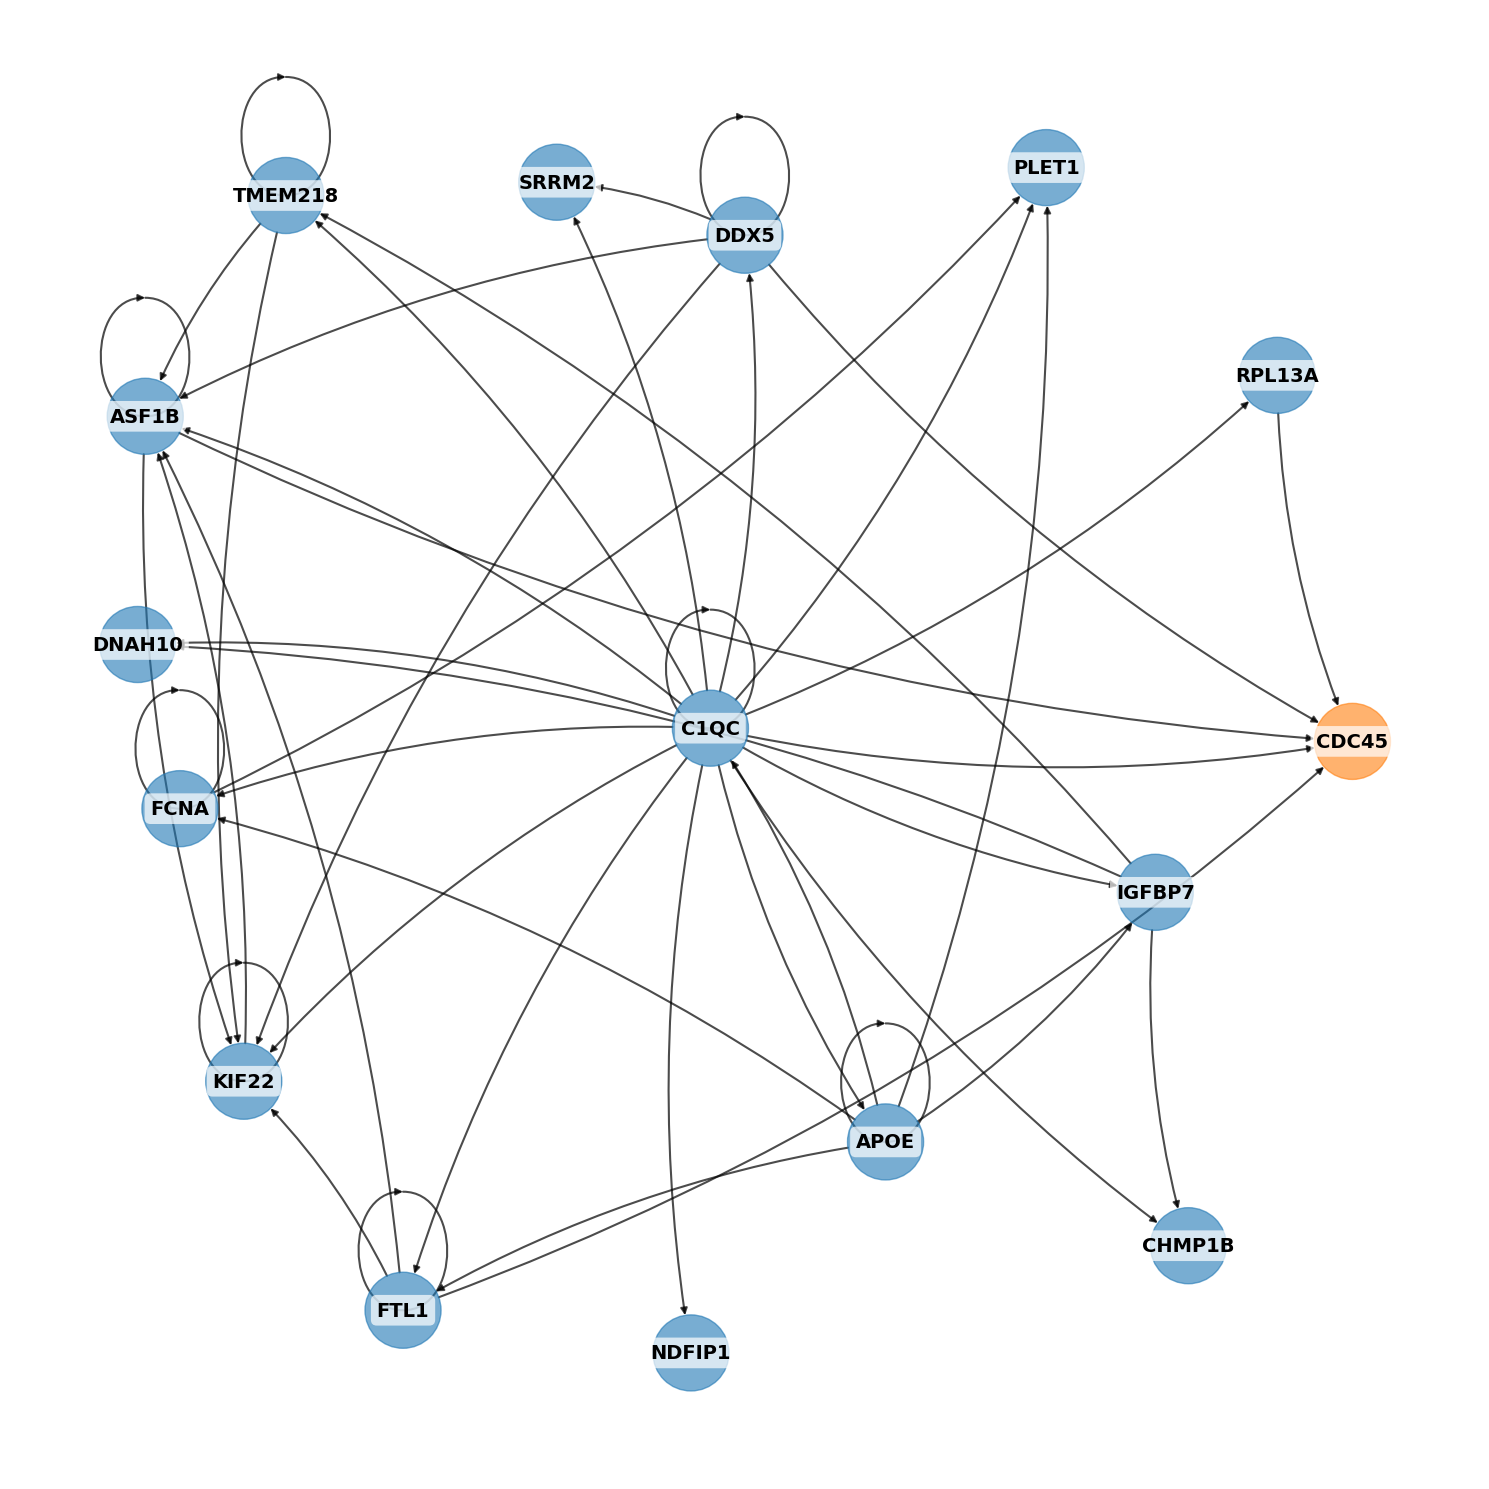

In [105]:
grn_m.plot_subgraph("CDC45", only=45, interactive=False, max_genes=15)

In [ ]:
fover = full[full.geneA.isin(list(res)) & full.geneB.isin(list(res))]
fover = fover.iloc[:, [1, 3, 4]].rename(
    columns={"RF2-PPI_interaction_probability": "value"}
)

['TMSB4X', 'APOE', 'C1QC', 'FTH1', 'B2M', 'FTL1', 'IFITM3', 'WFDC17', 'PABPC1', 'CD74', 'ITM2B', 'CTSD', 'MT-CYTB', 'RPLP1', 'MT-ND1']


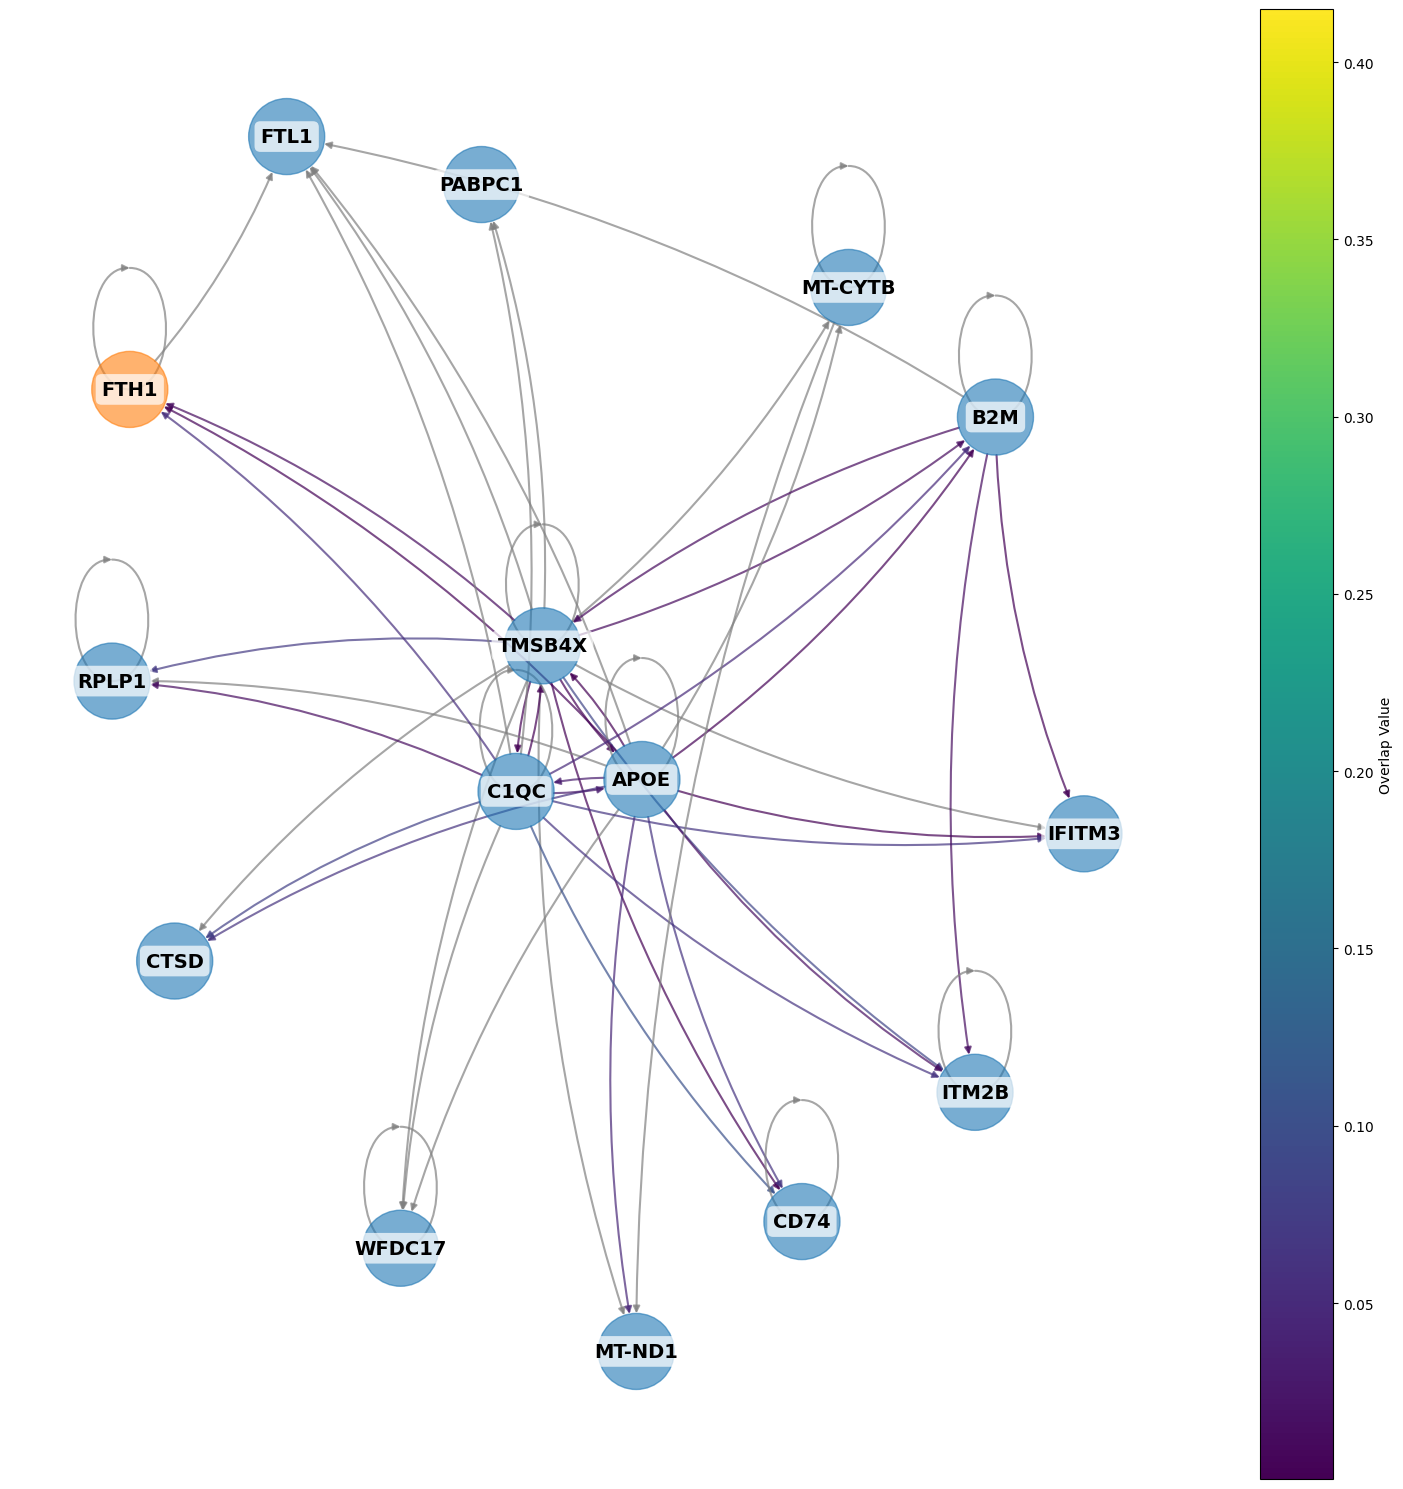

In [ ]:
res = grn_m.plot_subgraph(
    "FTH1", only=55, interactive=False, max_genes=15, color_overlap=fover
)

In [ ]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data"  #
gt_inter = read_h5ad(LOC + "/gt_humaninter.h5ad")
gt_inter

In [ ]:
gt_inter[:, gt_inter.var.symbol.isin(list(res))].grn

index,CD74,PABPC1,CTSD,ITM2B,RPLP1,IFITM3,C1QC,B2M,FTH1,MT-ND1,TMSB4X
index,,,,,,,,,,,
CD74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415,0.0,0.0,0.0
PABPC1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
CTSD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
ITM2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
RPLP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
IFITM3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
C1QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
B2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
FTH1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0


In [52]:
full = pd.read_parquet(LOC + "/RF2-PPI.parquet")

In [ ]:
# already we can see that our strong regulator cluster makes sense as 31 / 53 elements are connected to them
# in the core elements 25 over 31 of their connections were found by scprint
# B2M, C1QC, TMSB4X, TMSB4X 8/15

In [ ]:
from scipy.stats import fisher_exact, chi2_contingency
import numpy as np

# Observed data
# scPRINT connections: 31 out of 53 found
# Expected baseline: 8 out of 15 found

# Create contingency table
# Rows: scPRINT vs baseline
# Columns: found vs not found
contingency_table = np.array(
    [
        [(31 * 30), (53 * 30) - (31 * 30)],  # scPRINT: 31 found, 22 not found
        [(8 * 30), (15 * 30) - (8 * 30)],  # Baseline: 8 found, 7 not found
    ]
)

# Fisher's exact test (better for small sample sizes)
odds_ratio, p_value_fisher = fisher_exact(contingency_table, alternative="greater")
print(f"Fisher's exact test:")
print(f"  Odds ratio: {odds_ratio:.3f}")
print(f"  P-value: {p_value_fisher:.4f}")
# you would need 30x more samples to be able to say that

Fisher's exact test:
  Odds ratio: 1.233
  P-value: 0.0290


In [ ]:
C1QC - CTSD
APOE	C1QC
C1QC	ITM2B
C1QC	CD74
C1QC	RPLP1
B2M	IFITM3
RPLP1	TMSB4X
RPLP1	B2M X
CD74	TMSB4X
TMSB4X	ITM2B
APOE	B2M
APOE	IFITM3
C1QC	B2M
FTH1	TMSB4X
APOE	CTSD
B2M	TMSB4X
PABPC1	B2M x
CTSD	B2M x
APOE	ITM2B
APOE	CD74
APOE	FTH1
MT-ND1  B2M x
C1QC	FTH1
APOE	TMSB4X
C1QC	IFITM3
B2M	     ITM2B
C1QC	TMSB4X
CD74	B2M x
APOE	MT-ND1
FTH1	B2M x
FTH1    FTL
18085412	P07339_Q9Y287	0.136800	DNS	CTSD	ITM2B
18166937	P04233_P07339	0.105040	DNS	CD74	CTSD
19955382	P03886_Q9Y287	0.016980	DNS	MT-ND1	ITM2B
20020224	P03886_P04233	0.095500	DNS	MT-ND1	CD74
22679101	P03886_Q01628	0.032380	DNS	MT-ND1	IFITM3
26041344	P07339_P11940	0.161700	PPI	CTSD	PABPC1
26578045	P04233_P05386	0.001514	PPI	CD74	RPLP1
26584709	Q01628_Q9Y287	0.015470	PPI	IFITM3	ITM2B
26585809	P04233_Q01628	0.114000	PPI	CD74	IFITM3
28313270	P04233_P11940	0.135400	NEG	CD74	PABPC1
28640047	P05386_P11940	0.166900	DNU	RPLP1	PABPC1
29304732	P07339_Q01628	0.012840	NEG	CTSD	IFITM3
29585878	P04233_Q9Y287	0.142500	NEG	CD74	ITM2B
29753188	P05386_Q9Y287	0.042500	DNU	RPLP1	ITM2B
42674276	P05386_P07339	0.121150	DNU	RPLP1	CTSD
43974216	P03886_P05386	0.021640	DNU	MT-ND1	RPLP1
FTH1	PABPC1
FTH1	ITM2B
FTH1	CD74
FTH1	RPLP1
FTH1	IFITM3
FTH1	CTSD


In [ ]:
B2M, TMSB4X

In [53]:
full[full.geneA.isin(list(res)) & full.geneB.isin(list(res))]

,Pair,RF2-PPI_interaction_probability,Source,geneA,geneB
17002239,P02747_P07339,0.080600,DNS,C1QC,CTSD
18085412,P07339_Q9Y287,0.136800,DNS,CTSD,ITM2B
18166937,P04233_P07339,0.105040,DNS,CD74,CTSD
19955382,P03886_Q9Y287,0.016980,DNS,MT-ND1,ITM2B
20020224,P03886_P04233,0.095500,DNS,MT-ND1,CD74
20141399,P02649_P02747,0.029590,"PPI,DNS",APOE,C1QC
22679101,P03886_Q01628,0.032380,DNS,MT-ND1,IFITM3
22770104,P02747_Q9Y287,0.063350,DNS,C1QC,ITM2B
22847188,P02747_P04233,0.102700,DNS,C1QC,CD74
23135449,P02649_P61769,0.002630,"PPI,DNS",APOE,B2M


In [ ]:
fover = full[full.geneA.isin(list(res)) & full.geneB.isin(list(res))]
fover = fover.iloc[:, [1, 3, 4]].rename(
    columns={"RF2-PPI_interaction_probability": "value"}
)

['FTL', 'TMSB4X', 'B2M', 'FTH1', 'RPL31', 'HLA-DRA', 'SOD2', 'PPIA', 'CD74', 'S100A11', 'C1QA', 'CCL4', 'TXNIP', 'EIF1', 'C1QB']


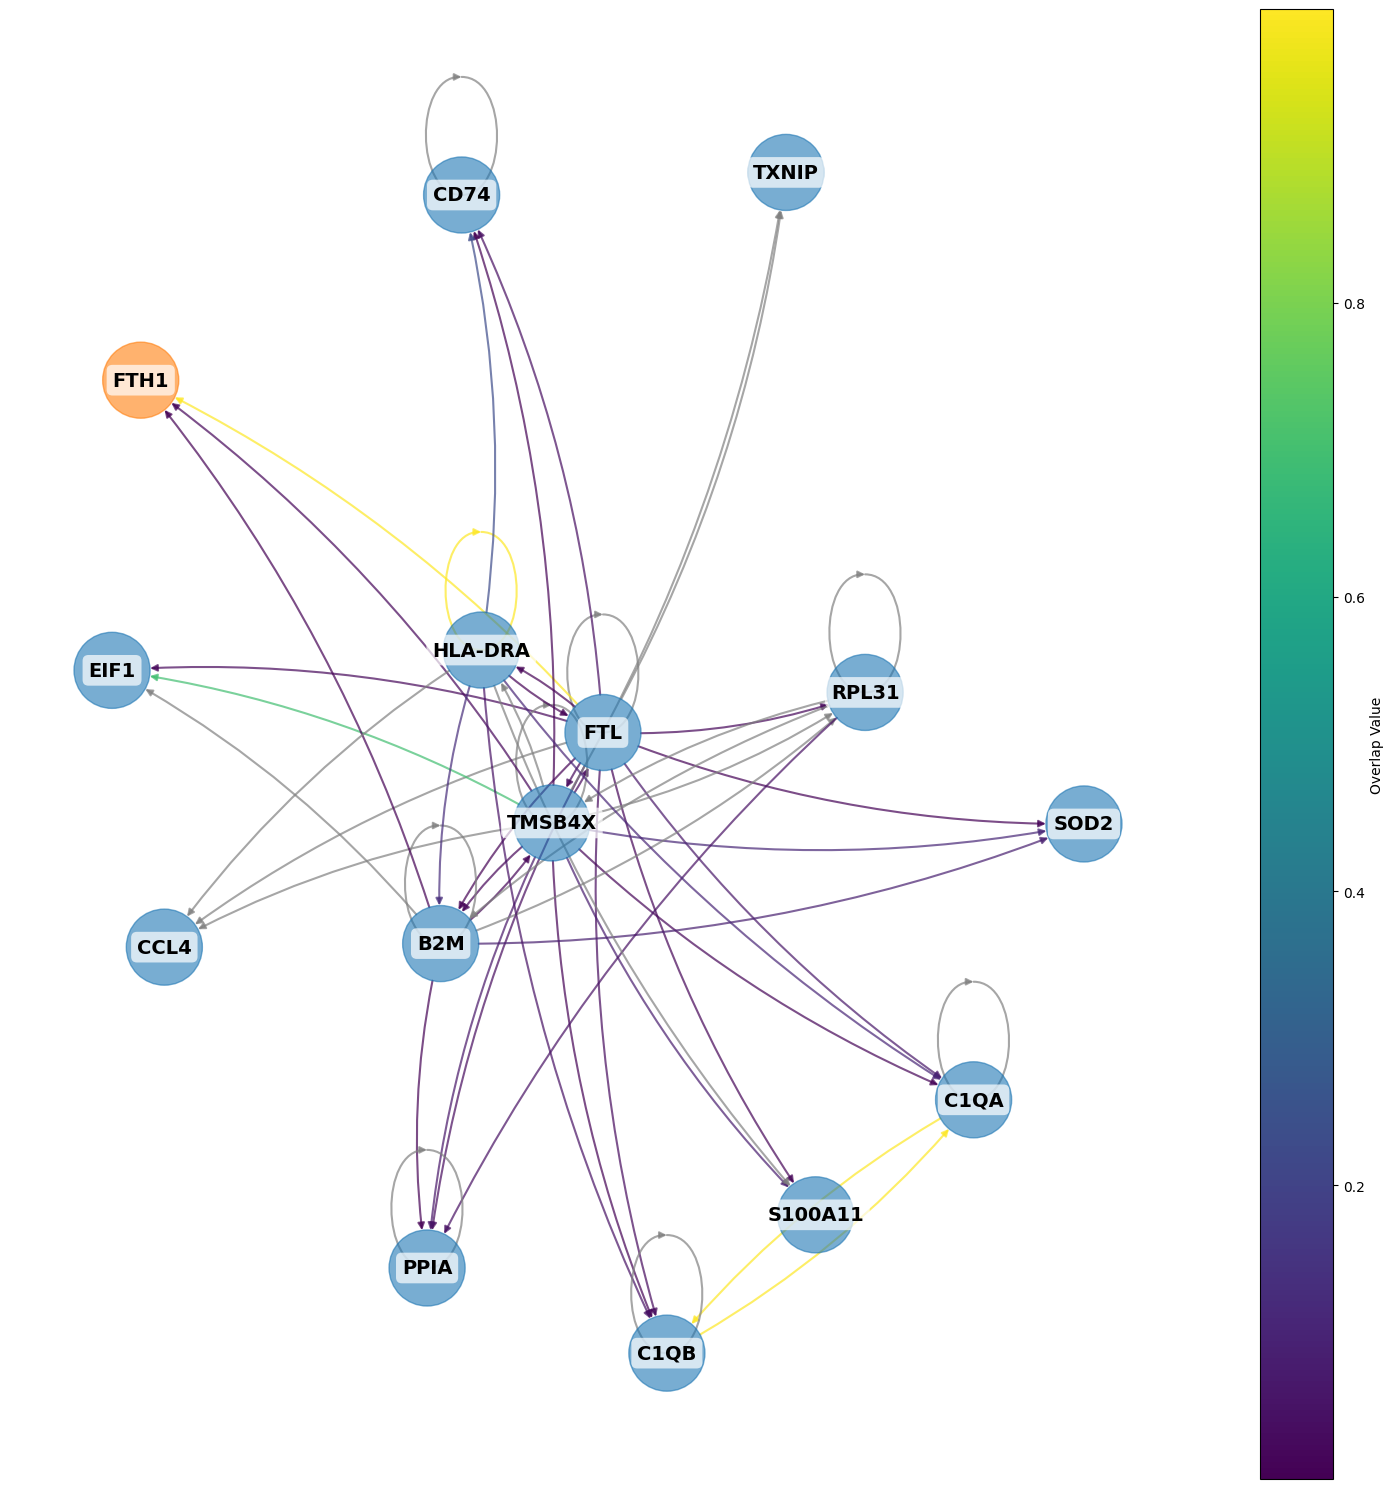

In [ ]:
res = grn_h.plot_subgraph(
    seed="FTH1", only=55, interactive=False, max_genes=15, color_overlap=fover
)

In [ ]:
gt_inter[:, gt_inter.var.symbol.isin(list(res))].grn

index,CD74,RPL31,FTL,S100A11,B2M,FTH1,C1QB,C1QA,EIF1,PPIA,HLA-DRA,TMSB4X,TXNIP,CCL4,SOD2
index,,,,,,,,,,,,,,,
CD74,0.0,0.0,0.0,0.0,0.415,0.0000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
RPL31,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
FTL,0.0,0.0,0.0,0.0,0.000,0.9976,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
S100A11,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
B2M,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
FTH1,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
C1QB,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
C1QA,0.0,0.0,0.0,0.0,0.000,0.0000,0.9995,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0
EIF1,0.0,0.0,0.0,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.000,0.6953,0.0,0.0,0.0


In [ ]:
# already we can see that our strong regulator cluster makes sense as 31 / 53 elements are connected to them
# in the core elements 25 over 31 of their connections were found by scprint

In [60]:
full[full.geneA.isin(list(res)) & full.geneB.isin(list(res))].head(40)

,Pair,RF2-PPI_interaction_probability,Source,geneA,geneB
21868837,A0A0G2JMH6_P01903,0.996000,"PPI,DNS",HLA-DRA,HLA-DRA
22621289,P02745_P02746,0.999500,"PPI,STR,DNS",C1QA,C1QB
22795634,P02746_P04233,0.056370,DNS,C1QB,CD74
23133146,P02746_P62937,0.031740,DNS,C1QB,PPIA
23465764,P02745_P04233,0.079000,DNS,C1QA,CD74
23710014,P02745_P62937,0.065100,DNS,C1QA,PPIA
24047859,P02794_P62937,0.011780,DNS,FTH1,PPIA
24314794,P02746_P61769,0.046630,DNS,C1QB,B2M
24689392,P02745_P61769,0.067500,DNS,C1QA,B2M
24731930,P62899_P62937,0.041600,DNS,RPL31,PPIA


In [59]:
full[full.geneA.isin(list(res)) & full.geneB.isin(list(res))].iloc[40:]

,Pair,RF2-PPI_interaction_probability,Source,geneA,geneB
29585268,P02794_P04179,0.006042,NEG,FTH1,SOD2
29605220,P02745_P02792,0.060670,DNU,C1QA,FTL
29608661,P02745_P02794,0.061920,NEG,C1QA,FTH1
29623038,P04233_P62937,0.020030,NEG,CD74,PPIA
29623946,P02794_P04233,0.022810,NEG,FTH1,CD74
29624075,P02792_P04233,0.037100,NEG,FTL,CD74
29653631,P02792_P62937,0.025830,DNU,FTL,PPIA
29705340,P02746_P31949,0.023300,NEG,C1QB,S100A11
29724467,P04179_P61769,0.084500,NEG,SOD2,B2M
29742954,P04179_P41567,0.076400,NEG,SOD2,EIF1


In [22]:
! wget --no-check-certificate -O $LOC/AF_scores.gz https://conglab.swmed.edu/humanPPI/downloads/AF_scores.gz

--2025-11-20 13:59:23--  https://conglab.swmed.edu/humanPPI/downloads/AF_scores.gz
Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 32359190 (31M) [application/x-gzip]
Saving to: ‘/pasteur/appa/scratch/jkalfon/data//AF_scores.gz’

/pasteur/appa/scrat 100%[===================>]  30.86M  15.0MB/s    in 2.1s    

2025-11-20 13:59:26 (15.0 MB/s) - ‘/pasteur/appa/scratch/jkalfon/data//AF_scores.gz’ saved [32359190/32359190]



In [ ]:
res = pd.read_csv(
    LOC + "/RF2-PPI.gz",
    sep="\t",
    # skiprows=7,
    header=None,  # nrows=100_000_000
)
res  # .columns = ["Pair", "RF2-PPI_interaction_probability", "Source"]

FileNotFoundError: [Errno 2] No such file or directory: '/pasteur/appa/scratch/jkalfon/data//RF2-PPI.gz'

In [ ]:
pd.read_csv("https://conglab.swmed.edu/humanPPI/downloads/AF_scores.gz", sep="\t")

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

# res

- seeing CD34 first is really cool (when most dissim human / mouse)

# pathway analysis

## mouse vs human

- many cell cyle genes
- replication genes
- G2-M Checkpoint / Mitotic Spindle
- DNA synthesis and replication, unwinding of dna...
- microtubulue, and tubulin stuff
- CDK1, MCM2, ..

## human vs mouse

- cytokine signaling
- Fluoropyrimidine, Pyrimidine and serine metabolism
- same otherwise

key differences in B-cell this also changes how they respond to cytokines and
influence in how they divide and replicate, That difference can be in part
driven by differences in nucleotide metabolism, which is key for DNA synthesis
and replication,

    •	Ortholog expression / enzyme activities differ: The DPD example shows mouse > human in hepatic activity. That suggests species have evolved different baseline enzyme capacities.
    •	Organ/tissue distribution of enzymes differs: The capecitabine study showed different organ/intestinal vs hepatic enzyme distributions in mice vs humans. That implies that even with the same genes, tissue‐expression context differs across species.
    •	Differences in precursor supply / flux: For serine, de novo synthesis vs uptake differs between species/tissue contexts. So B-cells in mouse may rely more on one mode (say, uptake) vs human B-cells another.
    •	Differences in regulation by signalling or metabolism: Immune cells in different species may use different metabolic wiring (e.g., nutrient transporter expression, mitochondrial vs glycolytic flux). These differences may ripple through nucleotide and serine metabolism.
    •	Evolutionary adaptation to lifespan, cell turnover, and metabolic demand: Mice have much faster cell proliferation rates, higher basal metabolic rates, shorter lifespans; this may drive differences in how strongly they rely on de novo synthesis vs salvage pathways, or how tightly pyrimidine catabolism is regulated.


In [ ]:
# Calculate dissimilarity for each common CD gene in human compared to mouse
dissim_scores = {}
for gene in subgrn_h.index:
    # Count overlapping connections (human vs mouse)
    overlap = (subgrn_h.loc[gene] & subgrn_m.loc[gene]).sum()
    # Dissimilarity score: how many top-K human connections are NOT present in mouse
    dissim_scores[gene] = (subgrn_h.loc[gene] & ~subgrn_m.loc[gene]).sum()

# Sort genes by dissimilarity (highest first)
dissim_df = pd.Series(dissim_scores).sort_values(ascending=False)
print("genes with most dissimilar top-K connections (human vs mouse):")
print(dissim_df.head(60))

# Show the most dissimilar genes
most_dissimilar = dissim_df.head(60).index.tolist()
print(f"\nMost dissimilar genes: {most_dissimilar}")

genes with most dissimilar top-K connections (human vs mouse):
GINS1       18
KIF22       18
UBE3A       18
MELK        18
SDC4        18
RFC3        18
GCH1        18
ACTR10      18
NSD1        18
PRR11       18
SHCBP1      18
SIVA1       18
BAZ1B       18
UBE2C       18
DMKN        18
PARPBP      18
RRM2        18
TXN2        18
CENPK       18
SPDL1       18
RAB11A      18
MCM7        18
MCM4        18
SLC25A39    18
CCNB1       18
TOP2A       18
CCNL2       18
CENPH       18
NUSAP1      18
KIF23       18
DHFR        18
SEC63       18
BRCA1       18
SNRNP27     18
GLRX5       18
ASF1B       18
GSDMD       18
SPPL2A      18
GINS2       18
RRM1        18
RRP7A       18
RACGAP1     18
FEN1        18
TYMS        18
PLK1        18
CCNB2       18
AK2         18
SUCLG1      18
CDC20       18
GMNN        18
RFC4        18
DNAJC19     18
DLGAP5      18
PAICS       18
NSRP1       18
MRPL34      18
EXOSC8      18
SPC25       18
KCNK1       18
NDUFA4L2    18
dtype: int64

Most dissimilar genes: 

In [ ]:
dissim_df.index[dissim_df.index.str.startswith("CD")]

Index(['CDC20', 'CDK1', 'CDC16', 'CD34', 'CDCA3', 'CDKAL1', 'CDO1', 'CDK4',
       'CD200R1', 'CDC34', 'CDKN2AIPNL', 'CDK14', 'CDKN1A', 'CDC37L1', 'CDC26',
       'CD36', 'CD93', 'CD68', 'CD83', 'CD14', 'CD69', 'CD40', 'CD47', 'CDC37',
       'CD63', 'CD46', 'CD52', 'CD3D'],
      dtype='object')

In [ ]:
K = 5
subgrn_h = grn_h.get(
    set(common) & set(grn_h.var.index[grn_h.var.index.str.match(r"CD\d{1,4}")])
).grn
subgrn_h = subgrn_h.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

subgrn_m = grn_m.get(
    set(common) & set(grn_m.var.index[grn_m.var.index.str.match(r"CD\d{1,4}")])
).grn
subgrn_m = subgrn_m.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
(subgrn_m & subgrn_h).sum(1).mean() / K

np.float64(0.5857142857142856)

In [ ]:
https://chatgpt.com/share/68ee40f1-7380-8000-b5ef-585db46704e9